In [18]:
# load tidy dataset

import pandas as pd
import os.path
import numpy as np
from itertools import combinations
import glob
import sys
import time
from sklearn import svm
from sklearn.model_selection import train_test_split
import pdb
import seaborn as sns
import matplotlib.pyplot as plt

## to increase the cell width of the notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


# from sklearn.learning_curve import learning_curve
# from sklearn.grid_search import GridSearchCV
# from sklearn.cross_validation import ShuffleSplit

def loadTidyTimings(tidyTimingsCSV): 
    assert os.path.isfile(tidyTimingsCSV), "desired file does not exist" 
    df = pd.read_csv(tidyTimingsCSV, header = None, names = ["animal", "session", "trial", "stimulus", "onsetFrame", "offsetFrame", "onsetTime", "offsetTime"])
    return df 

def loadTidyCalcium(tidyData): 
    assert os.path.isfile(tidyData), "desired file does not exist" 
    df = pd.read_csv(tidyData, header = None, names = ["date", "animal", "session", "trial", "stimulus", "neuronID", "timePt", "CaSignal"])
    return df 

# helper functions to return the number of distinct types in the provided data frame
getNumNeurons = lambda df: len(np.unique(df['neuronID'].tolist()))
getNeurons = lambda df: np.unique(df['neuronID'].tolist())

getNumTrials = lambda df: len(np.unique(df['trial'].tolist()))
getTrials = lambda df: np.unique(df['trial'].tolist())

getOnsetFrameNum = lambda animal, session, trial: df_timings.loc[(df_timings['animal']==animal) & (df_timings['session']==session) & (df_timings['trial']==trial), ['onsetFrame']].values[0][0]
getOffsetFrameNum = lambda animal, session, trial: df_timings.loc[(df_timings['animal']==animal) & (df_timings['session']==session) & (df_timings['trial']==trial), ['offsetFrame']].values[0][0]


# pass in pre-filtered data set containing data for only one animal and the same session (ie SAME NEURONS!)
def getListsOfTrialIDs(df_animalSession):
    ## get trials for both stimuli
    df_anmlSessStimA = df_animalSession[df_animalSession['stimulus'] == stimA]
    df_anmlSessStimB = df_animalSession[df_animalSession['stimulus'] == stimB]
    print(stimA,stimB)

    ## get lists of trial numbers of each stimuli's presentations 
    trials_stimA = np.unique(df_anmlSessStimA['trial'].tolist())
    trials_stimB = np.unique(df_anmlSessStimB['trial'].tolist())
    print("trial IDs for each stimulus type",trials_stimA,trials_stimB)
    return (trials_stimA,trials_stimB)

## pass in a data frame with only a single animal and session    
def getNumTimePtsPerTrial(df_animalSession, trials_stimA, trials_stimB):

    #### get number of timePts in each trial selected above 
    ## (1 to 3 presentations of the same stimuli exist per session in Prabhat's data)
    numTimePtsPerTrial = np.empty((2,max(len(trials_stimA),len(trials_stimB))))
    numTimePtsPerTrial[:] = np.nan
    stimInd = 0;
    for thisStimTypeTrialNums in [trials_stimA, trials_stimB]:
        trialInd = 0
        for trial in thisStimTypeTrialNums:
            inds_thisTrial = (df_animalSession['trial']==trial)
            tmp_df_thisTrial = df_animalSession[inds_thisTrial] # gives all time points for all neurons
            numNeurons = getNumNeurons(tmp_df_thisTrial) 
            numTimePtsPerTrial[stimInd,trialInd] = np.sum(inds_thisTrial)/numNeurons 
            trialInd += 1
        stimInd += 1
    print('stimuliType x presentationNum (row x col)')    
    print(numTimePtsPerTrial) # rows are for stimuli type; cols are presentation of that stimulus
    return numTimePtsPerTrial

## test candidate comparisons based on whether the number of trials per session and approximate number of timePts match
def areNumTrialsPerStimulusEqual(numTimePtsPerTrial):
    
    ## no trials of either type --> discard this comparison for this animal/session   
    if np.all(np.isnan(numTimePtsPerTrial)):
        print("DISCARDED: neither stimulus type were found for this animal and session")
        return False  # skip to next session (WORK: handle this)
        
    ## different numbers of trials per stimuli/session --> discard this comparison for this animal/session 
    elif np.any(np.isnan(numTimePtsPerTrial)): 
        print("DISCARDED: mismatching numbers of trials per stimulus type for this animal/session")
        return False # skip to next session (WORK: handle this)

    ## FULFILLED here: condition that allows analysis to proceed to attempted data
    elif not np.any(np.isnan(numTimePtsPerTrial)): 
        print("trial numbers match")
    else:
        raise RuntimeError('unexpected trial comparison occurred')
        return False
    
    print("checking approx num of time points")

## input argument generated from getNumTimePtsPerTrial
def areNumTimePtsPerTrialSimilar(numTimePtsPerTrial):
    if np.isnan(threshTPs_stdFromMean) == True:
        return True
    minTPs, maxTPs, meanTPs, stdTPs = timePtStats(numTimePtsPerTrial)             
    if (np.abs(minTPs-meanTPs) > (threshTPs_stdFromMean * np.abs(meanTPs-stdTPs))) \
        or (np.abs(maxTPs-meanTPs) > (threshTPs_stdFromMean * np.abs(meanTPs-stdTPs))): 
        print("DISCARDED: variance in trial length is above the user's threshold")
        return False # skip to next session (WORK: handle this)

    ### passed all criteria if it made it this far
    return True

## input argument created by getNumTimePtsPerTrial function
def timePtStats(numTimePtsPerTrial):
    minTPs = int(np.amin(numTimePtsPerTrial))
    maxTPs = int(np.amax(numTimePtsPerTrial))
    meanTPs = np.mean(numTimePtsPerTrial)
    stdTPs = np.std(numTimePtsPerTrial)

    ## useful for debugging
#     print('min', minTPs)
#     print('max', maxTPs)
#     print('std', stdTPs)
#     print('mean',meanTPs)
#     print('|min-mean|=',np.abs(minTPs-meanTPs))
#     print('|max-mean|=',np.abs(maxTPs-meanTPs))
#     print('|mean-std|=',np.abs(meanTPs-stdTPs))
#     print('thresh * |mean-std|=',(threshTPs_stdFromMean * np.abs(meanTPs-stdTPs)))
    
    return minTPs, maxTPs, meanTPs, stdTPs

def sameNeuronConcat(df_trunc, truncFrameNum):
    neuronArr_anmlSess_stimA = np.full((getNumNeurons(df_trunc),truncFrameNum-1), np.nan) # -1 for 0 indexing
    neuronArr_anmlSess_stimB = np.full((getNumNeurons(df_trunc),truncFrameNum-1), np.nan) # -1 for 0 indexing
    for stimLst in [trials_stimA, trials_stimB]:
        if np.array_equal(stimLst,trials_stimA) == True:
            print('\nstimulus:', stimA)
        elif np.array_equal(stimLst,trials_stimB) == True:
            print('\nstimulus:', stimB)
        else:
            raise RuntimeError('unexpected trial concatenation condition occurred')
        print('truncation frame: ', truncFrameNum)

        ## create temporary sub matrix of concatenated cells for ONE stimulus
        tmp_neuronsArr_sameStim = np.empty((getNumNeurons(df_trunc),truncFrameNum)) # no -1 DESPITE 0 indexing
        for trial in stimLst:
            print("appending same neurons in trial: ", trial)

            ##  create temporary sub matrix of same trial all cells
            tmp_neuronsArr_sameStim_sameTrial = np.empty((getNumNeurons(df_trunc),truncFrameNum)) # no -1 DESPITE 0 indexing
            for neuron in getNeurons(df_trunc):
                tmp_neuronInds = (df_trunc['trial']==trial) & (df_trunc['neuronID']==neuron)
                tmp_neuronSeries = df_trunc.loc[tmp_neuronInds,'CaSignal']
                
                ## pandas to numpy conversion
                tmp_neuronVec = tmp_neuronSeries.as_matrix()
                tmp_neuronsArr_sameStim_sameTrial[neuron-1,:] = tmp_neuronVec  
#                 print('neuronVec',np.shape(tmp_neuronVec))
#                 print('neuronsArr_sameStim_sameTrial', np.shape(tmp_neuronsArr_sameStim_sameTrial))
                 
            ## append trials to right of same stim if not the first entry
            if trial == stimLst[0]:
                tmp_neuronsArr_sameStim = np.copy(tmp_neuronsArr_sameStim_sameTrial)
            else:    
                tmp_neuronsArr_sameStim = np.concatenate((tmp_neuronsArr_sameStim, tmp_neuronsArr_sameStim_sameTrial), axis=1)
            print('same stim:', np.shape(tmp_neuronsArr_sameStim))

        ## save concatenated data to output variables
        if np.array_equal(stimLst,trials_stimA):
            neuronArr_anmlSess_stimA = tmp_neuronsArr_sameStim
        elif np.array_equal(stimLst,trials_stimB):
            neuronArr_anmlSess_stimB = tmp_neuronsArr_sameStim
        else:
            raise RuntimeError('unexpected same neuron concatenation state occured')
        
    return neuronArr_anmlSess_stimA, neuronArr_anmlSess_stimB
    
def selectTimePointsByMinStim():    
    minTPs, maxTPs, meanTPs, stdTPs = timePtStats(numTimePtsPerTrial)
    truncLst = []
    timingsMissing = False
    isFirstTrialExamined = True
    minStimulusDuration = []
    for trial in np.concatenate((trials_stimA,trials_stimB)):

        ## get stimulus timings
        onsetFrame = getOnsetFrameNum(animal,session,trial)
        offsetFrame = getOffsetFrameNum(animal,session,trial)
        stimulusDuration = offsetFrame - onsetFrame

        ## break out of both loops if timings are missing
        if np.isnan(onsetFrame) or np.isnan(offsetFrame):
            print('stimulus timing missing --> skipping')
            timingsMissing = True
            break

    ## timings are missing --> skip the rest of the analysis for this set of data  
    if timingsMissing == True: 
        return np.nan, np.nan, True  

    ## set as min if first or has min duration
    if isFirstTrialExamined == True:
        isFirstTrialExamined = False
        minStimulusDuration = stimulusDuration[()]
        print('first trial examined --> minStimDur is just the stimDur', minStimulusDuration)
    elif stimulusDuration[()] < minStimulusDuration and isFirstTrialExamined == False:
        print('new shortest is: ', stimulusDuration)
        minStimulusDuration = stimulusDuration[()]
    minStimulusDuration = int(minStimulusDuration)

    #### truncate data, then select time points, and save to new df
    truncLst = []
    print('trial concat', np.concatenate((trials_stimA,trials_stimB)))
    for trial in np.concatenate((trials_stimA,trials_stimB)):
        onsetFrame = getOnsetFrameNum(animal,session,trial)
        offsetFrame_chosen = onsetFrame + minStimulusDuration
        print('min stim dur', minStimulusDuration)
        print('onset frame', getOnsetFrameNum(animal,session,trial))
        print('offsetFrame_chosen: ',offsetFrame_chosen)

        tmp_inds_trunc = (df_animalSession['trial']==trial) & (df_animalSession['timePt'] >= onsetFrame.astype(int)) & (df_animalSession['timePt'] < offsetFrame_chosen.astype(int))
        tmp_df_trunc = df_animalSession[tmp_inds_trunc]
        truncLst.append(tmp_df_trunc)
    df_trunc = pd.concat(truncLst)

    ### just an optional sanity check
    print('num time pts in df_trunc')
    getNumTimePtsPerTrial(df_trunc, trials_stimA, trials_stimB) ### work
    ###

    #### concatenate same cells 
    ### loop over and concatenate neurons into the same row if they're the same neuron and stimuli 
    ##      (ie mouse, session, stimuli)
    print(animal,session)
    neuronArr_anmlSess_stimA, neuronArr_anmlSess_stimB = sameNeuronConcat(df_trunc, minStimulusDuration)
    print('shape', np.shape(neuronArr_anmlSess_stimA), np.shape(neuronArr_anmlSess_stimB))
    
    return neuronArr_anmlSess_stimA, neuronArr_anmlSess_stimB, False

def selectTimePointsByOneSecWindow():
    
    truncToMinPreStimPostDurations
    
    return neuronArr_anmlSess_stimA, neuronArr_anmlSess_stimB, False

In [2]:
################ concatenate all .csv files exported from matlab into single pandas dataframe df

### tidy csv file and dir (use makeTidy_Anderson.m to convert Ann's structure to csv)

## for Ubuntu laptop
tidyDataDir = '/home/orthogonull/a_MHR/aa_research/aa_gitResearch/git_ignored/imagingAnalysis/data/2_tidyCSVformat/' 
tidyTimingsFileAndPath = '/home/orthogonull/a_MHR/aa_research/aa_gitResearch/git_ignored/imagingAnalysis/data/2_tidyCSVformat/stimulusTimings.csv' # for Ubuntu laptop

## for Anderson desktop
# tidyDataDir = 'C:\\Users\\public.Analysis\\Desktop\\MHR\\git_ignored\data\\2_tidyCSVformat\\' 
# tidyTimingsFileAndPath = 'C:\\Users\\public.Analysis\\Desktop\\MHR\\git_ignored\\data\\2_tidyCSVformat\\stimulusTimings.csv' # for Anderson desktop

tidyDataFileTemplate = 'mouse'
tidyDataFileExt = '.csv'

dataTemplate = tidyDataDir + tidyDataFileTemplate + '*' + tidyDataFileExt 


print("loading stimulus timings into df_timings")
timingsLst = []
print(tidyTimingsFileAndPath)
timingsLst.append(loadTidyTimings(tidyTimingsFileAndPath))
df_timings = pd.concat(timingsLst)

# get all input files you want to add to the same dataset
dataFiles = np.sort(glob.glob(dataTemplate))
print("\n data files: \n", dataFiles)

print("\n loading and appending to prior pandas data frame")
dataLst = []

for file in dataFiles:
    print(file)
    dataLst.append(loadTidyCalcium(file))
df = pd.concat(dataLst)

print('finished loading')

############# ALL DATA STORED HERE IN DF
    

loading stimulus timings into df_timings
/home/orthogonull/a_MHR/aa_research/aa_gitResearch/git_ignored/imagingAnalysis/data/2_tidyCSVformat/stimulusTimings.csv

 data files: 
 [ '/home/orthogonull/a_MHR/aa_research/aa_gitResearch/git_ignored/imagingAnalysis/data/2_tidyCSVformat/mouse1.csv'
 '/home/orthogonull/a_MHR/aa_research/aa_gitResearch/git_ignored/imagingAnalysis/data/2_tidyCSVformat/mouse2.csv'
 '/home/orthogonull/a_MHR/aa_research/aa_gitResearch/git_ignored/imagingAnalysis/data/2_tidyCSVformat/mouse3.csv'
 '/home/orthogonull/a_MHR/aa_research/aa_gitResearch/git_ignored/imagingAnalysis/data/2_tidyCSVformat/mouse4.csv'
 '/home/orthogonull/a_MHR/aa_research/aa_gitResearch/git_ignored/imagingAnalysis/data/2_tidyCSVformat/mouse5.csv']

 loading and appending to prior pandas data frame
/home/orthogonull/a_MHR/aa_research/aa_gitResearch/git_ignored/imagingAnalysis/data/2_tidyCSVformat/mouse1.csv
/home/orthogonull/a_MHR/aa_research/aa_gitResearch/git_ignored/imagingAnalysis/data/2_tid

In [3]:
## survey/search data to prepare for split operation
metaStrs = [['dates','date'],['animals','animal'],['sessions','session'],['maxTrials','trial'],['stimuli','stimulus']]

print("searching over entire data set to get range of various IDs for data (used in subsequent loops)") 

## this dictionary holds useful info regarding the range of inputs to loop/search over subsequently
metaDct = {}
for a,b in metaStrs:
    print(a,b)
    metaDct[a] = np.unique(df[b].tolist())
print(metaDct)


searching over entire data set to get range of various IDs for data (used in subsequent loops)
dates date
animals animal
sessions session
maxTrials trial
stimuli stimulus
{'dates': array(['2017_05_00'], 
      dtype='<U10'), 'animals': array([1, 3, 4, 5, 7]), 'sessions': array([1, 2, 3]), 'maxTrials': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21]), 'stimuli': array(['USS', 'baseline', 'female', 'male', 'mineral oil odor',
       'peanut odor', 'pred odor', 'rat', 'tone', 'toy'], 
      dtype='<U16')}


In [11]:
######### USER PARAMETERS #########

## set to np.isnan if you don't want to filter based on number of TPs, play with value otherwise (less than ideal method but works) WORK: make this std of each type and not all types
threshTPs_stdFromMean = np.nan 

## SELECTION
# WORK: ADD USER STRING HERE



In [12]:
# get all pairs of stimuli
stimCmbTpl = tuple(combinations(metaDct['stimuli'],2)) 


######### MAIN LOOP ##########
df_SVM = pd.DataFrame(columns=('dateOfAnalysis', 'dateOfExperiment', 'animal', 'session', 'stimulusA', 'stimulusB', 'SVM_accuracy'))
ind_comparison = 0;
for (stimA, stimB) in stimCmbTpl:
    print((stimA,stimB))
    
    ## get all data for both trial types
    indsBoth = (df['stimulus']==stimA) | (df['stimulus']==stimB)
    df_bothStimuli = df[indsBoth]

    #### select data by animals and sessions
    for animal in metaDct['animals']:
        print("stimuli comparison num: ", ind_comparison+1)
        print('animal: ', animal)
        for session in metaDct['sessions']:
            print('session:', session)
            
            ## return subselection of data where the same neurons were recorded
            inds_animalSession = (df_bothStimuli['animal'] == animal) & (df_bothStimuli['session'] == session)
            df_animalSession = df_bothStimuli[inds_animalSession]
            try: 
                dateOfExperiment = df_animalSession['date'].values[0]
            except:
                dateOfExperiment = '?'
            print('date of exp:', dateOfExperiment)
            
            # get lists of trial IDs matching stimuli
            trials_stimA, trials_stimB = getListsOfTrialIDs(df_animalSession)
            
            #### skip this comparison <-- if the data don't match in number of trials 
            numTimePtsPerTrial = getNumTimePtsPerTrial(df_animalSession,trials_stimA,trials_stimB)
            if areNumTrialsPerStimulusEqual(numTimePtsPerTrial)==False:
                break     
                
#             #### skip this comparison <-- if the data don't match in approx number of timePts
            if areNumTimePtsPerTrialSimilar(numTimePtsPerTrial) == False:
                break
            
            ####################### MODIFY HERE TO CHANGE SELECTION CRITERIA
            #### select time points
            neuronArr_anmlSess_stimA, neuronArr_anmlSess_stimB, timingsMissing = selectTimePointsByMinStim() ### first analysis
#             neuronArr_anmlSess_stimA, neuronArr_anmlSess_stimB, timingsMissing = timePointsForOneSecWindow() ### second analysis
            
            ## skip if time stamps (annotations) are missing
            if timingsMissing == True:
                break
                
            ######### SVM #########
            
            ## create SVM format input by concatenating both classes (stimuli types); y is the labels
            print("stimA, stimB",np.shape(neuronArr_anmlSess_stimA), np.shape(neuronArr_anmlSess_stimB))
            X = np.concatenate((neuronArr_anmlSess_stimA, neuronArr_anmlSess_stimB), axis = 0)
            y = np.empty((neuronArr_anmlSess_stimA.shape[0]+neuronArr_anmlSess_stimB.shape[0]))
            y[:neuronArr_anmlSess_stimA.shape[0]] = 0
            y[neuronArr_anmlSess_stimB.shape[0]:] = 1
            print("X:", X.shape)
            print("y:", y.shape)
            
            print("k fold partitioning")
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
            
            print("training SVM")
            clf = svm.SVC(kernel='linear')
            
            ### WORK
            try:
                
                print(ind_comparison) 
                clf.fit(X_train, y_train)
                print("testing SVM")
                tmp_score = clf.score(X_test, y_test)
                print(tmp_score)
            except:
                print('X_train finite?: ', np.all(np.isfinite(X_train)))
                print('X_test finite?: ', np.all(np.isfinite(X_test)))
#                 np.savetxt("y_train_broken.csv", y_train, delimiter=",")
#                 np.savetxt("X_train_broken.csv", X_train, delimiter=",")
                pdb.set_trace()
            ### WORK
            
            ## add each SVM result to df
            analysisDate = pd.to_datetime('now')
            df_SVM.loc[ind_comparison] = [analysisDate, dateOfExperiment, animal, session, stimA, stimB, tmp_score]
#             print(df_SVM)

            ind_comparison += 1
            print('\n')
        print('########\n')
print('total number of comparisons: ', ind_comparison+1)

('USS', 'baseline')
stimuli comparison num:  1
animal:  1
session: 1
date of exp: 2017_05_00
USS baseline
trial IDs for each stimulus type [ 5 10 16] [ 1  8 15]
stimuliType x presentationNum (row x col)
[[ 1117.  1116.  1117.]
 [  370.   363.  1476.]]
trial numbers match
checking approx num of time points
stimulus timing missing --> skipping
########

stimuli comparison num:  1
animal:  3
session: 1
date of exp: 2017_05_00
USS baseline
trial IDs for each stimulus type [ 4 11 17] [ 1  8 15]
stimuliType x presentationNum (row x col)
[[ 1267.  1127.  1123.]
 [  674.   682.   678.]]
trial numbers match
checking approx num of time points
stimulus timing missing --> skipping
########

stimuli comparison num:  1
animal:  4
session: 1
date of exp: 2017_05_00
USS baseline
trial IDs for each stimulus type [ 4 11] []
stimuliType x presentationNum (row x col)
[[ 1137.  1113.]
 [   nan    nan]]
DISCARDED: mismatching numbers of trials per stimulus type for this animal/session
########

stimuli comp

same stim: (35, 141)
appending same neurons in trial:  13
same stim: (35, 282)
appending same neurons in trial:  17
same stim: (35, 423)
shape (35, 423) (35, 423)
stimA, stimB (35, 423) (35, 423)
X: (70, 423)
y: (70,)
k fold partitioning
training SVM
4
testing SVM
0.785714285714


session: 3
date of exp: 2017_05_00
USS female
trial IDs for each stimulus type [ 3 14 17] [ 4 13 16]
stimuliType x presentationNum (row x col)
[[ 1019.  1087.  1156.]
 [ 1010.  1002.  1019.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 127.0
trial concat [ 3 14 17  4 13 16]
min stim dur 127
onset frame 341.0
offsetFrame_chosen:  468.0
min stim dur 127
onset frame 339.0
offsetFrame_chosen:  466.0
min stim dur 127
onset frame 340.0
offsetFrame_chosen:  467.0
min stim dur 127
onset frame 354.0
offsetFrame_chosen:  481.0
min stim dur 127
onset frame 330.0
offsetFrame_chosen:  457.0
min stim dur 127
onset frame 360.0
offsetFrame_chosen:  487.0
num 

checking approx num of time points
first trial examined --> minStimDur is just the stimDur 115.0
trial concat [ 6 12 16  5 11 19]
min stim dur 115
onset frame 339.0
offsetFrame_chosen:  454.0
min stim dur 115
onset frame 338.0
offsetFrame_chosen:  453.0
min stim dur 115
onset frame 351.0
offsetFrame_chosen:  466.0
min stim dur 115
onset frame 349.0
offsetFrame_chosen:  464.0
min stim dur 115
onset frame 320.0
offsetFrame_chosen:  435.0
min stim dur 115
onset frame 361.0
offsetFrame_chosen:  476.0
num time pts in df_trunc
stimuliType x presentationNum (row x col)
[[ 115.  115.  115.]
 [ 115.  115.  115.]]
3 2

stimulus: USS
truncation frame:  115
appending same neurons in trial:  6
same stim: (35, 115)
appending same neurons in trial:  12
same stim: (35, 230)
appending same neurons in trial:  16
same stim: (35, 345)

stimulus: male
truncation frame:  115
appending same neurons in trial:  5
same stim: (35, 115)
appending same neurons in trial:  11
same stim: (35, 230)
appending same neur

USS male
trial IDs for each stimulus type [ 2 14] [ 7 10]
stimuliType x presentationNum (row x col)
[[ 1030.  1039.]
 [ 1040.  1018.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 111.0
trial concat [ 2 14  7 10]
min stim dur 111
onset frame 309.0
offsetFrame_chosen:  420.0
min stim dur 111
onset frame 309.0
offsetFrame_chosen:  420.0
min stim dur 111
onset frame 298.0
offsetFrame_chosen:  409.0
min stim dur 111
onset frame 320.0
offsetFrame_chosen:  431.0
num time pts in df_trunc
stimuliType x presentationNum (row x col)
[[ 111.  111.]
 [ 111.  111.]]
7 1

stimulus: USS
truncation frame:  111
appending same neurons in trial:  2
same stim: (57, 111)
appending same neurons in trial:  14
same stim: (57, 222)

stimulus: male
truncation frame:  111
appending same neurons in trial:  7
same stim: (57, 111)
appending same neurons in trial:  10
same stim: (57, 222)
shape (57, 222) (57, 222)
stimA, stimB (57, 222) (57, 222)
X: (1

same stim: (36, 111)
appending same neurons in trial:  15
same stim: (36, 222)
shape (36, 222) (36, 222)
stimA, stimB (36, 222) (36, 222)
X: (72, 222)
y: (72,)
k fold partitioning
training SVM
24
testing SVM
0.8


session: 2
date of exp: 2017_05_00
USS mineral oil odor
trial IDs for each stimulus type [3] [2]
stimuliType x presentationNum (row x col)
[[ 1251.]
 [ 1121.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 111.0
trial concat [3 2]
min stim dur 111
onset frame 342.0
offsetFrame_chosen:  453.0
min stim dur 111
onset frame 328.0
offsetFrame_chosen:  439.0
num time pts in df_trunc
stimuliType x presentationNum (row x col)
[[ 111.]
 [ 111.]]
5 2

stimulus: USS
truncation frame:  111
appending same neurons in trial:  3
same stim: (35, 111)

stimulus: mineral oil odor
truncation frame:  111
appending same neurons in trial:  2
same stim: (35, 111)
shape (35, 111) (35, 111)
stimA, stimB (35, 111) (35, 111)
X: (70, 111)
y

same stim: (49, 222)
shape (49, 222) (49, 222)
stimA, stimB (49, 222) (49, 222)
X: (98, 222)
y: (98,)
k fold partitioning
training SVM
31
testing SVM
0.85


session: 3
date of exp: 2017_05_00
USS peanut odor
trial IDs for each stimulus type [ 6 10] [ 8 13]
stimuliType x presentationNum (row x col)
[[ 1122.  1116.]
 [ 1239.  1133.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 111.0
trial concat [ 6 10  8 13]
min stim dur 111
onset frame 331.0
offsetFrame_chosen:  442.0
min stim dur 111
onset frame 331.0
offsetFrame_chosen:  442.0
min stim dur 111
onset frame 331.0
offsetFrame_chosen:  442.0
min stim dur 111
onset frame 335.0
offsetFrame_chosen:  446.0
num time pts in df_trunc
stimuliType x presentationNum (row x col)
[[ 111.  111.]
 [ 111.  111.]]
4 3

stimulus: USS
truncation frame:  111
appending same neurons in trial:  6
same stim: (47, 111)
appending same neurons in trial:  10
same stim: (47, 222)

stimulus: peanut o

same stim: (49, 222)
shape (49, 222) (49, 222)
stimA, stimB (49, 222) (49, 222)
X: (98, 222)
y: (98,)
k fold partitioning
training SVM
38
testing SVM
0.8


session: 3
date of exp: 2017_05_00
USS pred odor
trial IDs for each stimulus type [ 6 10] [ 3 12]
stimuliType x presentationNum (row x col)
[[ 1122.  1116.]
 [ 1121.  1116.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 111.0
trial concat [ 6 10  3 12]
min stim dur 111
onset frame 331.0
offsetFrame_chosen:  442.0
min stim dur 111
onset frame 331.0
offsetFrame_chosen:  442.0
min stim dur 111
onset frame 325.0
offsetFrame_chosen:  436.0
min stim dur 111
onset frame 333.0
offsetFrame_chosen:  444.0
num time pts in df_trunc
stimuliType x presentationNum (row x col)
[[ 111.  111.]
 [ 111.  111.]]
4 3

stimulus: USS
truncation frame:  111
appending same neurons in trial:  6
same stim: (47, 111)
appending same neurons in trial:  10
same stim: (47, 222)

stimulus: pred odor
t

same stim: (25, 345)

stimulus: rat
truncation frame:  115
appending same neurons in trial:  5
same stim: (25, 115)
appending same neurons in trial:  10
same stim: (25, 230)
appending same neurons in trial:  16
same stim: (25, 345)
shape (25, 345) (25, 345)
stimA, stimB (25, 345) (25, 345)
X: (50, 345)
y: (50,)
k fold partitioning
training SVM
45
testing SVM
0.7


session: 3
date of exp: 2017_05_00
USS rat
trial IDs for each stimulus type [ 6 13 16] [ 2 12 21]
stimuliType x presentationNum (row x col)
[[ 1139.  1140.  1232.]
 [ 1120.  1125.  1194.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 139.0
trial concat [ 6 13 16  2 12 21]
min stim dur 139
onset frame 339.0
offsetFrame_chosen:  478.0
min stim dur 139
onset frame 341.0
offsetFrame_chosen:  480.0
min stim dur 139
onset frame 343.0
offsetFrame_chosen:  482.0
min stim dur 139
onset frame 367.0
offsetFrame_chosen:  506.0
min stim dur 139
onset frame 345.0
offsetFrame

onset frame 331.0
offsetFrame_chosen:  442.0
min stim dur 111
onset frame 331.0
offsetFrame_chosen:  442.0
min stim dur 111
onset frame 379.0
offsetFrame_chosen:  490.0
min stim dur 111
onset frame 364.0
offsetFrame_chosen:  475.0
num time pts in df_trunc
stimuliType x presentationNum (row x col)
[[ 111.  111.]
 [ 111.  111.]]
4 3

stimulus: USS
truncation frame:  111
appending same neurons in trial:  6
same stim: (47, 111)
appending same neurons in trial:  10
same stim: (47, 222)

stimulus: rat
truncation frame:  111
appending same neurons in trial:  4
same stim: (47, 111)
appending same neurons in trial:  14
same stim: (47, 222)
shape (47, 222) (47, 222)
stimA, stimB (47, 222) (47, 222)
X: (94, 222)
y: (94,)
k fold partitioning
training SVM
52
testing SVM
0.842105263158


########

stimuli comparison num:  54
animal:  5
session: 1
date of exp: 2017_05_00
USS rat
trial IDs for each stimulus type [6 9] [ 2 16]
stimuliType x presentationNum (row x col)
[[ 1154.  1115.]
 [ 1171.  1121.]]

stimuliType x presentationNum (row x col)
[[ 1139.  1140.  1232.]
 [ 1118.  1135.  1225.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 110.0
trial concat [ 6 13 16  5  9 18]
min stim dur 110
onset frame 339.0
offsetFrame_chosen:  449.0
min stim dur 110
onset frame 341.0
offsetFrame_chosen:  451.0
min stim dur 110
onset frame 343.0
offsetFrame_chosen:  453.0
min stim dur 110
onset frame 348.0
offsetFrame_chosen:  458.0
min stim dur 110
onset frame 346.0
offsetFrame_chosen:  456.0
min stim dur 110
onset frame 339.0
offsetFrame_chosen:  449.0
num time pts in df_trunc
stimuliType x presentationNum (row x col)
[[ 110.  110.  110.]
 [ 110.  110.  110.]]
1 3

stimulus: USS
truncation frame:  110
appending same neurons in trial:  6
same stim: (21, 110)
appending same neurons in trial:  13
same stim: (21, 220)
appending same neurons in trial:  16
same stim: (21, 330)

stimulus: tone
truncation frame:  110
appending same neurons 

same stim: (47, 222)

stimulus: tone
truncation frame:  111
appending same neurons in trial:  2
same stim: (47, 111)
appending same neurons in trial:  15
same stim: (47, 222)
shape (47, 222) (47, 222)
stimA, stimB (47, 222) (47, 222)
X: (94, 222)
y: (94,)
k fold partitioning
training SVM
65
testing SVM
0.631578947368


########

stimuli comparison num:  67
animal:  5
session: 1
date of exp: 2017_05_00
USS tone
trial IDs for each stimulus type [6 9] [ 1 12]
stimuliType x presentationNum (row x col)
[[ 1154.  1115.]
 [ 1120.  1140.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 101.0
trial concat [ 6  9  1 12]
min stim dur 101
onset frame 335.0
offsetFrame_chosen:  436.0
min stim dur 101
onset frame 335.0
offsetFrame_chosen:  436.0
min stim dur 101
onset frame 341.0
offsetFrame_chosen:  442.0
min stim dur 101
onset frame 342.0
offsetFrame_chosen:  443.0
num time pts in df_trunc
stimuliType x presentationNum (row x col)
[[ 

USS toy
trial IDs for each stimulus type [ 4 11 21] [ 3 12 19]
stimuliType x presentationNum (row x col)
[[ 1015.  1329.  1214.]
 [ 1131.  1114.  1113.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 111.0
trial concat [ 4 11 21  3 12 19]
min stim dur 111
onset frame 330.0
offsetFrame_chosen:  441.0
min stim dur 111
onset frame 345.0
offsetFrame_chosen:  456.0
min stim dur 111
onset frame 382.0
offsetFrame_chosen:  493.0
min stim dur 111
onset frame 397.0
offsetFrame_chosen:  508.0
min stim dur 111
onset frame 296.0
offsetFrame_chosen:  407.0
min stim dur 111
onset frame 353.0
offsetFrame_chosen:  464.0
num time pts in df_trunc
stimuliType x presentationNum (row x col)
[[ 111.  111.  111.]
 [ 111.  111.  111.]]
1 2

stimulus: USS
truncation frame:  111
appending same neurons in trial:  4
same stim: (25, 111)
appending same neurons in trial:  11
same stim: (25, 222)
appending same neurons in trial:  21
same stim: (25, 333)

stimuliType x presentationNum (row x col)
[[ 1133.  1124.]
 [ 1120.  1122.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 111.0
trial concat [ 5  9  2 15]
min stim dur 111
onset frame 331.0
offsetFrame_chosen:  442.0
min stim dur 111
onset frame 336.0
offsetFrame_chosen:  447.0
min stim dur 111
onset frame 339.0
offsetFrame_chosen:  450.0
min stim dur 111
onset frame 331.0
offsetFrame_chosen:  442.0
num time pts in df_trunc
stimuliType x presentationNum (row x col)
[[ 111.  111.]
 [ 111.  111.]]
4 2

stimulus: USS
truncation frame:  111
appending same neurons in trial:  5
same stim: (49, 111)
appending same neurons in trial:  9
same stim: (49, 222)

stimulus: toy
truncation frame:  111
appending same neurons in trial:  2
same stim: (49, 111)
appending same neurons in trial:  15
same stim: (49, 222)
shape (49, 222) (49, 222)
stimA, stimB (49, 222) (49, 222)
X: (98, 222)
y: (98,)
k fold partitioning
training SVM
79
testing

appending same neurons in trial:  12
same stim: (54, 222)

stimulus: toy
truncation frame:  111
appending same neurons in trial:  5
same stim: (54, 111)
appending same neurons in trial:  15
same stim: (54, 222)
shape (54, 222) (54, 222)
stimA, stimB (54, 222) (54, 222)
X: (108, 222)
y: (108,)
k fold partitioning
training SVM
86
testing SVM
0.636363636364


########

('baseline', 'female')
stimuli comparison num:  88
animal:  1
session: 1
date of exp: 2017_05_00
baseline female
trial IDs for each stimulus type [ 1  8 15] [ 4 11 20]
stimuliType x presentationNum (row x col)
[[  370.   363.  1476.]
 [ 1126.  1245.  1112.]]
trial numbers match
checking approx num of time points
stimulus timing missing --> skipping
########

stimuli comparison num:  88
animal:  3
session: 1
date of exp: 2017_05_00
baseline female
trial IDs for each stimulus type [ 1  8 15] [ 7  9 19]
stimuliType x presentationNum (row x col)
[[  674.   682.   678.]
 [ 1114.  1116.  1115.]]
trial numbers match
checking appro

stimuliType x presentationNum (row x col)
[[  674.   682.   678.]
 [ 1147.  1211.  1112.]]
trial numbers match
checking approx num of time points
stimulus timing missing --> skipping
########

stimuli comparison num:  88
animal:  4
session: 1
date of exp: 2017_05_00
baseline rat
trial IDs for each stimulus type [] [ 2 16]
stimuliType x presentationNum (row x col)
[[   nan    nan]
 [ 1233.  1133.]]
DISCARDED: mismatching numbers of trials per stimulus type for this animal/session
########

stimuli comparison num:  88
animal:  5
session: 1
date of exp: 2017_05_00
baseline rat
trial IDs for each stimulus type [] [ 2 16]
stimuliType x presentationNum (row x col)
[[   nan    nan]
 [ 1171.  1121.]]
DISCARDED: mismatching numbers of trials per stimulus type for this animal/session
########

stimuli comparison num:  88
animal:  7
session: 1
date of exp: 2017_05_00
baseline rat
trial IDs for each stimulus type [] [ 4 15]
stimuliType x presentationNum (row x col)
[[   nan    nan]
 [ 1029.  1021.

female male
trial IDs for each stimulus type [ 7  9 19] [ 5 12 16]
stimuliType x presentationNum (row x col)
[[ 1114.  1116.  1115.]
 [ 1123.  1108.  1138.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 149.0
trial concat [ 7  9 19  5 12 16]
min stim dur 149
onset frame 354.0
offsetFrame_chosen:  503.0
min stim dur 149
onset frame 383.0
offsetFrame_chosen:  532.0
min stim dur 149
onset frame 356.0
offsetFrame_chosen:  505.0
min stim dur 149
onset frame 345.0
offsetFrame_chosen:  494.0
min stim dur 149
onset frame 348.0
offsetFrame_chosen:  497.0
min stim dur 149
onset frame 339.0
offsetFrame_chosen:  488.0
num time pts in df_trunc
stimuliType x presentationNum (row x col)
[[ 149.  149.  149.]
 [ 149.  149.  149.]]
3 1

stimulus: female
truncation frame:  149
appending same neurons in trial:  7
same stim: (30, 149)
appending same neurons in trial:  9
same stim: (30, 298)
appending same neurons in trial:  19
same stim: (30

stimuli comparison num:  94
animal:  1
session: 1
date of exp: 2017_05_00
female pred odor
trial IDs for each stimulus type [ 4 11 20] []
stimuliType x presentationNum (row x col)
[[ 1126.  1245.  1112.]
 [   nan    nan    nan]]
DISCARDED: mismatching numbers of trials per stimulus type for this animal/session
########

stimuli comparison num:  94
animal:  3
session: 1
date of exp: 2017_05_00
female pred odor
trial IDs for each stimulus type [ 7  9 19] []
stimuliType x presentationNum (row x col)
[[ 1114.  1116.  1115.]
 [   nan    nan    nan]]
DISCARDED: mismatching numbers of trials per stimulus type for this animal/session
########

stimuli comparison num:  94
animal:  4
session: 1
date of exp: 2017_05_00
female pred odor
trial IDs for each stimulus type [] [ 5 15]
stimuliType x presentationNum (row x col)
[[   nan    nan]
 [ 1118.  1112.]]
DISCARDED: mismatching numbers of trials per stimulus type for this animal/session
########

stimuli comparison num:  94
animal:  5
session: 1
d

same stim: (35, 134)
appending same neurons in trial:  9
same stim: (35, 268)
appending same neurons in trial:  18
same stim: (35, 402)
shape (35, 402) (35, 402)
stimA, stimB (35, 402) (35, 402)
X: (70, 402)
y: (70,)
k fold partitioning
training SVM
97
testing SVM
0.714285714286


session: 3
date of exp: 2017_05_00
female rat
trial IDs for each stimulus type [ 4 13 16] [ 5 10 21]
stimuliType x presentationNum (row x col)
[[ 1010.  1002.  1019.]
 [ 1098.  1144.  1026.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 119.0
trial concat [ 4 13 16  5 10 21]
min stim dur 119
onset frame 354.0
offsetFrame_chosen:  473.0
min stim dur 119
onset frame 330.0
offsetFrame_chosen:  449.0
min stim dur 119
onset frame 360.0
offsetFrame_chosen:  479.0
min stim dur 119
onset frame 376.0
offsetFrame_chosen:  495.0
min stim dur 119
onset frame 424.0
offsetFrame_chosen:  543.0
min stim dur 119
onset frame 399.0
offsetFrame_chosen:  518.0
num 

female tone
trial IDs for each stimulus type [ 3 13 17] [ 2 14 20]
stimuliType x presentationNum (row x col)
[[  893.   941.  1015.]
 [  978.  1435.  1000.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 110.0
trial concat [ 3 13 17  2 14 20]
min stim dur 110
onset frame 339.0
offsetFrame_chosen:  449.0
min stim dur 110
onset frame 355.0
offsetFrame_chosen:  465.0
min stim dur 110
onset frame 338.0
offsetFrame_chosen:  448.0
min stim dur 110
onset frame 338.0
offsetFrame_chosen:  448.0
min stim dur 110
onset frame 339.0
offsetFrame_chosen:  449.0
min stim dur 110
onset frame 383.0
offsetFrame_chosen:  493.0
num time pts in df_trunc
stimuliType x presentationNum (row x col)
[[ 110.  110.  110.]
 [ 110.  110.  110.]]
3 2

stimulus: female
truncation frame:  110
appending same neurons in trial:  3
same stim: (35, 110)
appending same neurons in trial:  13
same stim: (35, 220)
appending same neurons in trial:  17
same stim: (3

same stim: (30, 356)
appending same neurons in trial:  19
same stim: (30, 534)

stimulus: toy
truncation frame:  178
appending same neurons in trial:  6
same stim: (30, 178)
appending same neurons in trial:  10
same stim: (30, 356)
appending same neurons in trial:  21
same stim: (30, 534)
shape (30, 534) (30, 534)
stimA, stimB (30, 534) (30, 534)
X: (60, 534)
y: (60,)
k fold partitioning
training SVM
108
testing SVM
0.833333333333


session: 2
date of exp: 2017_05_00
female toy
trial IDs for each stimulus type [ 3 13 17] [ 7 10 21]
stimuliType x presentationNum (row x col)
[[  893.   941.  1015.]
 [  913.   896.   913.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 123.0
trial concat [ 3 13 17  7 10 21]
min stim dur 123
onset frame 339.0
offsetFrame_chosen:  462.0
min stim dur 123
onset frame 355.0
offsetFrame_chosen:  478.0
min stim dur 123
onset frame 338.0
offsetFrame_chosen:  461.0
min stim dur 123
onset frame 343.0


same stim: (36, 111)
appending same neurons in trial:  11
same stim: (36, 222)

stimulus: mineral oil odor
truncation frame:  111
appending same neurons in trial:  4
same stim: (36, 111)
appending same neurons in trial:  15
same stim: (36, 222)
shape (36, 222) (36, 222)
stimA, stimB (36, 222) (36, 222)
X: (72, 222)
y: (72,)
k fold partitioning
training SVM
114
testing SVM
0.533333333333


session: 2
date of exp: 2017_05_00
male mineral oil odor
trial IDs for each stimulus type [7] [2]
stimuliType x presentationNum (row x col)
[[ 1109.]
 [ 1121.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 111.0
trial concat [7 2]
min stim dur 111
onset frame 308.0
offsetFrame_chosen:  419.0
min stim dur 111
onset frame 328.0
offsetFrame_chosen:  439.0
num time pts in df_trunc
stimuliType x presentationNum (row x col)
[[ 111.]
 [ 111.]]
5 2

stimulus: male
truncation frame:  111
appending same neurons in trial:  7
same stim: (35, 111)



same stim: (49, 222)

stimulus: peanut odor
truncation frame:  111
appending same neurons in trial:  4
same stim: (49, 111)
appending same neurons in trial:  16
same stim: (49, 222)
shape (49, 222) (49, 222)
stimA, stimB (49, 222) (49, 222)
X: (98, 222)
y: (98,)
k fold partitioning
training SVM
121
testing SVM
0.75


session: 3
date of exp: 2017_05_00
male peanut odor
trial IDs for each stimulus type [ 1 11] [ 8 13]
stimuliType x presentationNum (row x col)
[[ 1125.  1130.]
 [ 1239.  1133.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 111.0
trial concat [ 1 11  8 13]
min stim dur 111
onset frame 344.0
offsetFrame_chosen:  455.0
min stim dur 111
onset frame 353.0
offsetFrame_chosen:  464.0
min stim dur 111
onset frame 331.0
offsetFrame_chosen:  442.0
min stim dur 111
onset frame 335.0
offsetFrame_chosen:  446.0
num time pts in df_trunc
stimuliType x presentationNum (row x col)
[[ 111.  111.]
 [ 111.  111.]]
4 3

stimulus

stimuliType x presentationNum (row x col)
[[ 1125.  1114.]
 [ 1146.  1125.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 111.0
trial concat [ 3 11  1 13]
min stim dur 111
onset frame 342.0
offsetFrame_chosen:  453.0
min stim dur 111
onset frame 324.0
offsetFrame_chosen:  435.0
min stim dur 111
onset frame 331.0
offsetFrame_chosen:  442.0
min stim dur 111
onset frame 363.0
offsetFrame_chosen:  474.0
num time pts in df_trunc
stimuliType x presentationNum (row x col)
[[ 111.  111.]
 [ 111.  111.]]
4 2

stimulus: male
truncation frame:  111
appending same neurons in trial:  3
same stim: (49, 111)
appending same neurons in trial:  11
same stim: (49, 222)

stimulus: pred odor
truncation frame:  111
appending same neurons in trial:  1
same stim: (49, 111)
appending same neurons in trial:  13
same stim: (49, 222)
shape (49, 222) (49, 222)
stimA, stimB (49, 222) (49, 222)
X: (98, 222)
y: (98,)
k fold partitioning
training SVM
12

male rat
trial IDs for each stimulus type [ 2 13 18] [ 5 10 16]
stimuliType x presentationNum (row x col)
[[ 1166.  1113.  1167.]
 [ 1120.  1114.  1322.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 115.0
trial concat [ 2 13 18  5 10 16]
min stim dur 115
onset frame 366.0
offsetFrame_chosen:  481.0
min stim dur 115
onset frame 379.0
offsetFrame_chosen:  494.0
min stim dur 115
onset frame 380.0
offsetFrame_chosen:  495.0
min stim dur 115
onset frame 376.0
offsetFrame_chosen:  491.0
min stim dur 115
onset frame 397.0
offsetFrame_chosen:  512.0
min stim dur 115
onset frame 443.0
offsetFrame_chosen:  558.0
num time pts in df_trunc
stimuliType x presentationNum (row x col)
[[ 115.  115.  115.]
 [ 115.  115.  115.]]
1 2

stimulus: male
truncation frame:  115
appending same neurons in trial:  2
same stim: (25, 115)
appending same neurons in trial:  13
same stim: (25, 230)
appending same neurons in trial:  18
same stim: (25, 34

min stim dur 111
onset frame 345.0
offsetFrame_chosen:  456.0
num time pts in df_trunc
stimuliType x presentationNum (row x col)
[[ 111.  111.]
 [ 111.  111.]]
4 2

stimulus: male
truncation frame:  111
appending same neurons in trial:  3
same stim: (49, 111)
appending same neurons in trial:  11
same stim: (49, 222)

stimulus: rat
truncation frame:  111
appending same neurons in trial:  8
same stim: (49, 111)
appending same neurons in trial:  14
same stim: (49, 222)
shape (49, 222) (49, 222)
stimA, stimB (49, 222) (49, 222)
X: (98, 222)
y: (98,)
k fold partitioning
training SVM
141
testing SVM
0.8


session: 3
date of exp: 2017_05_00
male rat
trial IDs for each stimulus type [ 1 11] [ 4 14]
stimuliType x presentationNum (row x col)
[[ 1125.  1130.]
 [ 1148.  1129.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 111.0
trial concat [ 1 11  4 14]
min stim dur 111
onset frame 344.0
offsetFrame_chosen:  455.0
min stim dur 111


same stim: (25, 220)
appending same neurons in trial:  18
same stim: (25, 330)

stimulus: tone
truncation frame:  110
appending same neurons in trial:  6
same stim: (25, 110)
appending same neurons in trial:  14
same stim: (25, 220)
appending same neurons in trial:  17
same stim: (25, 330)
shape (25, 330) (25, 330)
stimA, stimB (25, 330) (25, 330)
X: (50, 330)
y: (50,)
k fold partitioning
training SVM
148
testing SVM
0.5


session: 3
date of exp: 2017_05_00
male tone
trial IDs for each stimulus type [ 4 11 19] [ 5  9 18]
stimuliType x presentationNum (row x col)
[[ 1134.  1114.  1168.]
 [ 1118.  1135.  1225.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 110.0
trial concat [ 4 11 19  5  9 18]
min stim dur 110
onset frame 353.0
offsetFrame_chosen:  463.0
min stim dur 110
onset frame 374.0
offsetFrame_chosen:  484.0
min stim dur 110
onset frame 380.0
offsetFrame_chosen:  490.0
min stim dur 110
onset frame 348.0
offsetFrame

stimuliType x presentationNum (row x col)
[[ 111.  111.]
 [ 111.  111.]]
4 3

stimulus: male
truncation frame:  111
appending same neurons in trial:  1
same stim: (47, 111)
appending same neurons in trial:  11
same stim: (47, 222)

stimulus: tone
truncation frame:  111
appending same neurons in trial:  2
same stim: (47, 111)
appending same neurons in trial:  15
same stim: (47, 222)
shape (47, 222) (47, 222)
stimA, stimB (47, 222) (47, 222)
X: (94, 222)
y: (94,)
k fold partitioning
training SVM
155
testing SVM
0.789473684211


########

stimuli comparison num:  157
animal:  5
session: 1
date of exp: 2017_05_00
male tone
trial IDs for each stimulus type [ 8 11] [ 1 12]
stimuliType x presentationNum (row x col)
[[ 1119.  1131.]
 [ 1120.  1140.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 101.0
trial concat [ 8 11  1 12]
min stim dur 101
onset frame 309.0
offsetFrame_chosen:  410.0
min stim dur 101
onset frame 342.0
offset

date of exp: 2017_05_00
male toy
trial IDs for each stimulus type [ 2 13 18] [ 3 12 19]
stimuliType x presentationNum (row x col)
[[ 1166.  1113.  1167.]
 [ 1131.  1114.  1113.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 111.0
trial concat [ 2 13 18  3 12 19]
min stim dur 111
onset frame 366.0
offsetFrame_chosen:  477.0
min stim dur 111
onset frame 379.0
offsetFrame_chosen:  490.0
min stim dur 111
onset frame 380.0
offsetFrame_chosen:  491.0
min stim dur 111
onset frame 397.0
offsetFrame_chosen:  508.0
min stim dur 111
onset frame 296.0
offsetFrame_chosen:  407.0
min stim dur 111
onset frame 353.0
offsetFrame_chosen:  464.0
num time pts in df_trunc
stimuliType x presentationNum (row x col)
[[ 111.  111.  111.]
 [ 111.  111.  111.]]
1 2

stimulus: male
truncation frame:  111
appending same neurons in trial:  2
same stim: (25, 111)
appending same neurons in trial:  13
same stim: (25, 222)
appending same neurons in trial

male toy
trial IDs for each stimulus type [ 3 11] [ 2 15]
stimuliType x presentationNum (row x col)
[[ 1125.  1114.]
 [ 1120.  1122.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 111.0
trial concat [ 3 11  2 15]
min stim dur 111
onset frame 342.0
offsetFrame_chosen:  453.0
min stim dur 111
onset frame 324.0
offsetFrame_chosen:  435.0
min stim dur 111
onset frame 339.0
offsetFrame_chosen:  450.0
min stim dur 111
onset frame 331.0
offsetFrame_chosen:  442.0
num time pts in df_trunc
stimuliType x presentationNum (row x col)
[[ 111.  111.]
 [ 111.  111.]]
4 2

stimulus: male
truncation frame:  111
appending same neurons in trial:  3
same stim: (49, 111)
appending same neurons in trial:  11
same stim: (49, 222)

stimulus: toy
truncation frame:  111
appending same neurons in trial:  2
same stim: (49, 111)
appending same neurons in trial:  15
same stim: (49, 222)
shape (49, 222) (49, 222)
stimA, stimB (49, 222) (49, 222)
X: (9

same stim: (54, 222)
shape (54, 222) (54, 222)
stimA, stimB (54, 222) (54, 222)
X: (108, 222)
y: (108,)
k fold partitioning
training SVM
176
testing SVM
0.909090909091


########

('mineral oil odor', 'peanut odor')
stimuli comparison num:  178
animal:  1
session: 1
date of exp: ?
mineral oil odor peanut odor
trial IDs for each stimulus type [] []
stimuliType x presentationNum (row x col)
[]
DISCARDED: neither stimulus type were found for this animal and session
########

stimuli comparison num:  178
animal:  3
session: 1
date of exp: ?
mineral oil odor peanut odor
trial IDs for each stimulus type [] []
stimuliType x presentationNum (row x col)
[]
DISCARDED: neither stimulus type were found for this animal and session
########

stimuli comparison num:  178
animal:  4
session: 1
date of exp: 2017_05_00
mineral oil odor peanut odor
trial IDs for each stimulus type [ 3 12] [7 9]
stimuliType x presentationNum (row x col)
[[ 1131.  1110.]
 [ 1171.  1152.]]
trial numbers match
checking appro

same stim: (54, 222)

stimulus: peanut odor
truncation frame:  111
appending same neurons in trial:  3
same stim: (54, 111)
appending same neurons in trial:  11
same stim: (54, 222)
shape (54, 222) (54, 222)
stimA, stimB (54, 222) (54, 222)
X: (108, 222)
y: (108,)
k fold partitioning
training SVM
183
testing SVM
0.818181818182


########

('mineral oil odor', 'pred odor')
stimuli comparison num:  185
animal:  1
session: 1
date of exp: ?
mineral oil odor pred odor
trial IDs for each stimulus type [] []
stimuliType x presentationNum (row x col)
[]
DISCARDED: neither stimulus type were found for this animal and session
########

stimuli comparison num:  185
animal:  3
session: 1
date of exp: ?
mineral oil odor pred odor
trial IDs for each stimulus type [] []
stimuliType x presentationNum (row x col)
[]
DISCARDED: neither stimulus type were found for this animal and session
########

stimuli comparison num:  185
animal:  4
session: 1
date of exp: 2017_05_00
mineral oil odor pred odor
trial

min stim dur 111
onset frame 271.0
offsetFrame_chosen:  382.0
min stim dur 111
onset frame 292.0
offsetFrame_chosen:  403.0
num time pts in df_trunc
stimuliType x presentationNum (row x col)
[[ 111.  111.]
 [ 111.  111.]]
7 3

stimulus: mineral oil odor
truncation frame:  111
appending same neurons in trial:  2
same stim: (54, 111)
appending same neurons in trial:  14
same stim: (54, 222)

stimulus: pred odor
truncation frame:  111
appending same neurons in trial:  4
same stim: (54, 111)
appending same neurons in trial:  16
same stim: (54, 222)
shape (54, 222) (54, 222)
stimA, stimB (54, 222) (54, 222)
X: (108, 222)
y: (108,)
k fold partitioning
training SVM
190
testing SVM
0.772727272727


########

('mineral oil odor', 'rat')
stimuli comparison num:  192
animal:  1
session: 1
date of exp: 2017_05_00
mineral oil odor rat
trial IDs for each stimulus type [] [ 3 14 18]
stimuliType x presentationNum (row x col)
[[   nan    nan    nan]
 [ 1132.  1137.  1109.]]
DISCARDED: mismatching numbe

same stim: (40, 222)

stimulus: rat
truncation frame:  111
appending same neurons in trial:  1
same stim: (40, 111)
appending same neurons in trial:  16
same stim: (40, 222)
shape (40, 222) (40, 222)
stimA, stimB (40, 222) (40, 222)
X: (80, 222)
y: (80,)
k fold partitioning
training SVM
196
testing SVM
0.6875


session: 3
date of exp: 2017_05_00
mineral oil odor rat
trial IDs for each stimulus type [ 2 14] [ 8 13]
stimuliType x presentationNum (row x col)
[[ 1010.  1015.]
 [ 1016.  1018.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 101.0
trial concat [ 2 14  8 13]
min stim dur 101
onset frame 276.0
offsetFrame_chosen:  377.0
min stim dur 101
onset frame 287.0
offsetFrame_chosen:  388.0
min stim dur 101
onset frame 309.0
offsetFrame_chosen:  410.0
min stim dur 101
onset frame 309.0
offsetFrame_chosen:  410.0
num time pts in df_trunc
stimuliType x presentationNum (row x col)
[[ 101.  101.]
 [ 101.  101.]]
7 3

stimulus: 

mineral oil odor tone
trial IDs for each stimulus type [ 3 16] [ 6 11]
stimuliType x presentationNum (row x col)
[[ 1012.  1019.]
 [ 1009.  1016.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 111.0
trial concat [ 3 16  6 11]
min stim dur 111
onset frame 287.0
offsetFrame_chosen:  398.0
min stim dur 111
onset frame 301.0
offsetFrame_chosen:  412.0
min stim dur 111
onset frame 298.0
offsetFrame_chosen:  409.0
min stim dur 111
onset frame 320.0
offsetFrame_chosen:  431.0
num time pts in df_trunc
stimuliType x presentationNum (row x col)
[[ 111.  111.]
 [ 111.  111.]]
7 1

stimulus: mineral oil odor
truncation frame:  111
appending same neurons in trial:  3
same stim: (57, 111)
appending same neurons in trial:  16
same stim: (57, 222)

stimulus: tone
truncation frame:  111
appending same neurons in trial:  6
same stim: (57, 111)
appending same neurons in trial:  11
same stim: (57, 222)
shape (57, 222) (57, 222)
stimA, stimB

same stim: (36, 111)
appending same neurons in trial:  14
same stim: (36, 222)
shape (36, 222) (36, 222)
stimA, stimB (36, 222) (36, 222)
X: (72, 222)
y: (72,)
k fold partitioning
training SVM
210
testing SVM
0.6


session: 2
date of exp: 2017_05_00
mineral oil odor toy
trial IDs for each stimulus type [2] [4]
stimuliType x presentationNum (row x col)
[[ 1121.]
 [ 1113.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 111.0
trial concat [2 4]
min stim dur 111
onset frame 328.0
offsetFrame_chosen:  439.0
min stim dur 111
onset frame 309.0
offsetFrame_chosen:  420.0
num time pts in df_trunc
stimuliType x presentationNum (row x col)
[[ 111.]
 [ 111.]]
5 2

stimulus: mineral oil odor
truncation frame:  111
appending same neurons in trial:  2
same stim: (35, 111)

stimulus: toy
truncation frame:  111
appending same neurons in trial:  4
same stim: (35, 111)
shape (35, 111) (35, 111)
stimA, stimB (35, 111) (35, 111)
X: (70, 111)


same stim: (49, 222)
shape (49, 222) (49, 222)
stimA, stimB (49, 222) (49, 222)
X: (98, 222)
y: (98,)
k fold partitioning
training SVM
217
testing SVM
0.9


session: 3
date of exp: 2017_05_00
peanut odor pred odor
trial IDs for each stimulus type [ 8 13] [ 3 12]
stimuliType x presentationNum (row x col)
[[ 1239.  1133.]
 [ 1121.  1116.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 111.0
trial concat [ 8 13  3 12]
min stim dur 111
onset frame 331.0
offsetFrame_chosen:  442.0
min stim dur 111
onset frame 335.0
offsetFrame_chosen:  446.0
min stim dur 111
onset frame 325.0
offsetFrame_chosen:  436.0
min stim dur 111
onset frame 333.0
offsetFrame_chosen:  444.0
num time pts in df_trunc
stimuliType x presentationNum (row x col)
[[ 111.  111.]
 [ 111.  111.]]
4 3

stimulus: peanut odor
truncation frame:  111
appending same neurons in trial:  8
same stim: (47, 111)
appending same neurons in trial:  13
same stim: (47, 222)

stim

stimuli comparison num:  226
animal:  1
session: 1
date of exp: 2017_05_00
peanut odor rat
trial IDs for each stimulus type [] [ 3 14 18]
stimuliType x presentationNum (row x col)
[[   nan    nan    nan]
 [ 1132.  1137.  1109.]]
DISCARDED: mismatching numbers of trials per stimulus type for this animal/session
########

stimuli comparison num:  226
animal:  3
session: 1
date of exp: 2017_05_00
peanut odor rat
trial IDs for each stimulus type [] [ 2 14 18]
stimuliType x presentationNum (row x col)
[[   nan    nan    nan]
 [ 1147.  1211.  1112.]]
DISCARDED: mismatching numbers of trials per stimulus type for this animal/session
########

stimuli comparison num:  226
animal:  4
session: 1
date of exp: 2017_05_00
peanut odor rat
trial IDs for each stimulus type [7 9] [ 2 16]
stimuliType x presentationNum (row x col)
[[ 1171.  1152.]
 [ 1233.  1133.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 111.0
trial concat [ 7  9  2 1

same stim: (57, 222)

stimulus: rat
truncation frame:  111
appending same neurons in trial:  4
same stim: (57, 111)
appending same neurons in trial:  15
same stim: (57, 222)
shape (57, 222) (57, 222)
stimA, stimB (57, 222) (57, 222)
X: (114, 222)
y: (114,)
k fold partitioning
training SVM
231
testing SVM
0.869565217391


session: 2
date of exp: 2017_05_00
peanut odor rat
trial IDs for each stimulus type [4 9] [ 1 16]
stimuliType x presentationNum (row x col)
[[ 1014.  1160.]
 [ 1016.  1016.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 111.0
trial concat [ 4  9  1 16]
min stim dur 111
onset frame 287.0
offsetFrame_chosen:  398.0
min stim dur 111
onset frame 326.0
offsetFrame_chosen:  437.0
min stim dur 111
onset frame 298.0
offsetFrame_chosen:  409.0
min stim dur 111
onset frame 302.0
offsetFrame_chosen:  413.0
num time pts in df_trunc
stimuliType x presentationNum (row x col)
[[ 111.  111.]
 [ 111.  111.]]
7 2

stimulu

peanut odor tone
trial IDs for each stimulus type [ 8 13] [ 6 11]
stimuliType x presentationNum (row x col)
[[ 1024.  1012.]
 [ 1009.  1016.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 111.0
trial concat [ 8 13  6 11]
min stim dur 111
onset frame 298.0
offsetFrame_chosen:  409.0
min stim dur 111
onset frame 289.0
offsetFrame_chosen:  400.0
min stim dur 111
onset frame 298.0
offsetFrame_chosen:  409.0
min stim dur 111
onset frame 320.0
offsetFrame_chosen:  431.0
num time pts in df_trunc
stimuliType x presentationNum (row x col)
[[ 111.  111.]
 [ 111.  111.]]
7 1

stimulus: peanut odor
truncation frame:  111
appending same neurons in trial:  8
same stim: (57, 111)
appending same neurons in trial:  13
same stim: (57, 222)

stimulus: tone
truncation frame:  111
appending same neurons in trial:  6
same stim: (57, 111)
appending same neurons in trial:  11
same stim: (57, 222)
shape (57, 222) (57, 222)
stimA, stimB (57, 222)

same stim: (36, 111)
appending same neurons in trial:  14
same stim: (36, 222)
shape (36, 222) (36, 222)
stimA, stimB (36, 222) (36, 222)
X: (72, 222)
y: (72,)
k fold partitioning
training SVM
244
testing SVM
0.466666666667


session: 2
date of exp: 2017_05_00
peanut odor toy
trial IDs for each stimulus type [ 1 11] [4]
stimuliType x presentationNum (row x col)
[[ 1175.  1208.]
 [ 1113.    nan]]
DISCARDED: mismatching numbers of trials per stimulus type for this animal/session
########

stimuli comparison num:  246
animal:  7
session: 1
date of exp: 2017_05_00
peanut odor toy
trial IDs for each stimulus type [ 8 13] [ 1 12]
stimuliType x presentationNum (row x col)
[[ 1024.  1012.]
 [ 1016.  1015.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 111.0
trial concat [ 8 13  1 12]
min stim dur 111
onset frame 298.0
offsetFrame_chosen:  409.0
min stim dur 111
onset frame 289.0
offsetFrame_chosen:  400.0
min stim dur 111
onset 

same stim: (36, 111)
appending same neurons in trial:  10
same stim: (36, 222)

stimulus: rat
truncation frame:  111
appending same neurons in trial:  2
same stim: (36, 111)
appending same neurons in trial:  16
same stim: (36, 222)
shape (36, 222) (36, 222)
stimA, stimB (36, 222) (36, 222)
X: (72, 222)
y: (72,)
k fold partitioning
training SVM
251
testing SVM
0.666666666667


session: 2
date of exp: 2017_05_00
pred odor rat
trial IDs for each stimulus type [ 5 10] [6 9]
stimuliType x presentationNum (row x col)
[[ 1216.  1111.]
 [ 1127.  1115.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 111.0
trial concat [ 5 10  6  9]
min stim dur 111
onset frame 321.0
offsetFrame_chosen:  432.0
min stim dur 111
onset frame 322.0
offsetFrame_chosen:  433.0
min stim dur 111
onset frame 309.0
offsetFrame_chosen:  420.0
min stim dur 111
onset frame 331.0
offsetFrame_chosen:  442.0
num time pts in df_trunc
stimuliType x presentationNum (

same stim: (49, 222)
shape (49, 222) (49, 222)
stimA, stimB (49, 222) (49, 222)
X: (98, 222)
y: (98,)
k fold partitioning
training SVM
258
testing SVM
0.8


session: 3
date of exp: 2017_05_00
pred odor tone
trial IDs for each stimulus type [ 3 12] [ 2 15]
stimuliType x presentationNum (row x col)
[[ 1121.  1116.]
 [ 1119.  1123.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 111.0
trial concat [ 3 12  2 15]
min stim dur 111
onset frame 325.0
offsetFrame_chosen:  436.0
min stim dur 111
onset frame 333.0
offsetFrame_chosen:  444.0
min stim dur 111
onset frame 336.0
offsetFrame_chosen:  447.0
min stim dur 111
onset frame 342.0
offsetFrame_chosen:  453.0
num time pts in df_trunc
stimuliType x presentationNum (row x col)
[[ 111.  111.]
 [ 111.  111.]]
4 3

stimulus: pred odor
truncation frame:  111
appending same neurons in trial:  3
same stim: (47, 111)
appending same neurons in trial:  12
same stim: (47, 222)

stimulus: ton

same stim: (49, 222)

stimulus: toy
truncation frame:  111
appending same neurons in trial:  2
same stim: (49, 111)
appending same neurons in trial:  15
same stim: (49, 222)
shape (49, 222) (49, 222)
stimA, stimB (49, 222) (49, 222)
X: (98, 222)
y: (98,)
k fold partitioning
training SVM
265
testing SVM
1.0


session: 3
date of exp: 2017_05_00
pred odor toy
trial IDs for each stimulus type [ 3 12] [7 9]
stimuliType x presentationNum (row x col)
[[ 1121.  1116.]
 [ 1120.  1152.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 111.0
trial concat [ 3 12  7  9]
min stim dur 111
onset frame 325.0
offsetFrame_chosen:  436.0
min stim dur 111
onset frame 333.0
offsetFrame_chosen:  444.0
min stim dur 111
onset frame 334.0
offsetFrame_chosen:  445.0
min stim dur 111
onset frame 329.0
offsetFrame_chosen:  440.0
num time pts in df_trunc
stimuliType x presentationNum (row x col)
[[ 111.  111.]
 [ 111.  111.]]
4 3

stimulus: pred odor
tr

same stim: (25, 220)
appending same neurons in trial:  16
same stim: (25, 330)

stimulus: tone
truncation frame:  110
appending same neurons in trial:  6
same stim: (25, 110)
appending same neurons in trial:  14
same stim: (25, 220)
appending same neurons in trial:  17
same stim: (25, 330)
shape (25, 330) (25, 330)
stimA, stimB (25, 330) (25, 330)
X: (50, 330)
y: (50,)
k fold partitioning
training SVM
272
testing SVM
0.9


session: 3
date of exp: 2017_05_00
rat tone
trial IDs for each stimulus type [ 2 12 21] [ 5  9 18]
stimuliType x presentationNum (row x col)
[[ 1120.  1125.  1194.]
 [ 1118.  1135.  1225.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 110.0
trial concat [ 2 12 21  5  9 18]
min stim dur 110
onset frame 367.0
offsetFrame_chosen:  477.0
min stim dur 110
onset frame 345.0
offsetFrame_chosen:  455.0
min stim dur 110
onset frame 392.0
offsetFrame_chosen:  502.0
min stim dur 110
onset frame 348.0
offsetFrame_

stimuliType x presentationNum (row x col)
[[ 111.  111.]
 [ 111.  111.]]
4 3

stimulus: rat
truncation frame:  111
appending same neurons in trial:  4
same stim: (47, 111)
appending same neurons in trial:  14
same stim: (47, 222)

stimulus: tone
truncation frame:  111
appending same neurons in trial:  2
same stim: (47, 111)
appending same neurons in trial:  15
same stim: (47, 222)
shape (47, 222) (47, 222)
stimA, stimB (47, 222) (47, 222)
X: (94, 222)
y: (94,)
k fold partitioning
training SVM
279
testing SVM
0.947368421053


########

stimuli comparison num:  281
animal:  5
session: 1
date of exp: 2017_05_00
rat tone
trial IDs for each stimulus type [ 2 16] [ 1 12]
stimuliType x presentationNum (row x col)
[[ 1171.  1121.]
 [ 1120.  1140.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 101.0
trial concat [ 2 16  1 12]
min stim dur 101
onset frame 348.0
offsetFrame_chosen:  449.0
min stim dur 101
onset frame 332.0
offsetFr

first trial examined --> minStimDur is just the stimDur 156.0
trial concat [ 2 12 21  7 10 20]
min stim dur 156
onset frame 367.0
offsetFrame_chosen:  523.0
min stim dur 156
onset frame 345.0
offsetFrame_chosen:  501.0
min stim dur 156
onset frame 392.0
offsetFrame_chosen:  548.0
min stim dur 156
onset frame 334.0
offsetFrame_chosen:  490.0
min stim dur 156
onset frame 367.0
offsetFrame_chosen:  523.0
min stim dur 156
onset frame 337.0
offsetFrame_chosen:  493.0
num time pts in df_trunc
stimuliType x presentationNum (row x col)
[[ 156.  156.  156.]
 [ 156.  156.  156.]]
1 3

stimulus: rat
truncation frame:  156
appending same neurons in trial:  2
same stim: (21, 156)
appending same neurons in trial:  12
same stim: (21, 312)
appending same neurons in trial:  21
same stim: (21, 468)

stimulus: toy
truncation frame:  156
appending same neurons in trial:  7
same stim: (21, 156)
appending same neurons in trial:  10
same stim: (21, 312)
appending same neurons in trial:  20
same stim: (21, 46

same stim: (47, 111)
appending same neurons in trial:  14
same stim: (47, 222)

stimulus: toy
truncation frame:  111
appending same neurons in trial:  7
same stim: (47, 111)
appending same neurons in trial:  9
same stim: (47, 222)
shape (47, 222) (47, 222)
stimA, stimB (47, 222) (47, 222)
X: (94, 222)
y: (94,)
k fold partitioning
training SVM
292
testing SVM
0.947368421053


########

stimuli comparison num:  294
animal:  5
session: 1
date of exp: 2017_05_00
rat toy
trial IDs for each stimulus type [ 2 16] [ 5 14]
stimuliType x presentationNum (row x col)
[[ 1171.  1121.]
 [ 1130.  1349.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 111.0
trial concat [ 2 16  5 14]
min stim dur 111
onset frame 348.0
offsetFrame_chosen:  459.0
min stim dur 111
onset frame 332.0
offsetFrame_chosen:  443.0
min stim dur 111
onset frame 321.0
offsetFrame_chosen:  432.0
min stim dur 111
onset frame 315.0
offsetFrame_chosen:  426.0
num time pt

same stim: (21, 312)
appending same neurons in trial:  20
same stim: (21, 468)
shape (21, 468) (21, 468)
stimA, stimB (21, 468) (21, 468)
X: (42, 468)
y: (42,)
k fold partitioning
training SVM
299
testing SVM
0.666666666667


########

stimuli comparison num:  301
animal:  3
session: 1
date of exp: 2017_05_00
tone toy
trial IDs for each stimulus type [ 3 13 20] [ 6 10 21]
stimuliType x presentationNum (row x col)
[[ 1332.  1111.  1120.]
 [ 1109.  1124.  1114.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 178.0
trial concat [ 3 13 20  6 10 21]
min stim dur 178
onset frame 343.0
offsetFrame_chosen:  521.0
min stim dur 178
onset frame 339.0
offsetFrame_chosen:  517.0
min stim dur 178
onset frame 341.0
offsetFrame_chosen:  519.0
min stim dur 178
onset frame 353.0
offsetFrame_chosen:  531.0
min stim dur 178
onset frame 344.0
offsetFrame_chosen:  522.0
min stim dur 178
onset frame 362.0
offsetFrame_chosen:  540.0
num time pts

same stim: (36, 111)
appending same neurons in trial:  14
same stim: (36, 222)
shape (36, 222) (36, 222)
stimA, stimB (36, 222) (36, 222)
X: (72, 222)
y: (72,)
k fold partitioning
training SVM
306
testing SVM
0.8


session: 2
date of exp: 2017_05_00
tone toy
trial IDs for each stimulus type [8] [4]
stimuliType x presentationNum (row x col)
[[ 1119.]
 [ 1113.]]
trial numbers match
checking approx num of time points
first trial examined --> minStimDur is just the stimDur 111.0
trial concat [8 4]
min stim dur 111
onset frame 338.0
offsetFrame_chosen:  449.0
min stim dur 111
onset frame 309.0
offsetFrame_chosen:  420.0
num time pts in df_trunc
stimuliType x presentationNum (row x col)
[[ 111.]
 [ 111.]]
5 2

stimulus: tone
truncation frame:  111
appending same neurons in trial:  8
same stim: (35, 111)

stimulus: toy
truncation frame:  111
appending same neurons in trial:  4
same stim: (35, 111)
shape (35, 111) (35, 111)
stimA, stimB (35, 111) (35, 111)
X: (70, 111)
y: (70,)
k fold partitio

In [ ]:
## buffer cell
pdb.set_trace()

np.savetxt("X_train.csv", X_train, delimiter=",")

            #             tmp_SVMresult = pd.DataFrame({"animal": [animal]})#,{"testAccuracy": tmp_score})
#             tmp_SVMresult = pd.DataFrame([animal], columns = list([1])) #,{"testAccuracy": tmp_score})
#             df_SVM.loc[df_SVM.index.max() + 1] = [animal, session, tmp_score]
#             df_SVM.loc[totalNumComparisons] = [animal, session, tmp_score]
#             df_SVM.loc[totalNumComparisons] = [0,1,2]
#             df_SVM = pd.DataFrame({'mouse': animal, 'session': session, 'SVMaccuracy': tmp_score}, index =totalNumComparisons)
#             df_SVM.iloc[1] = dict(x=9, y=99)
#             df_SVM.append(tmp_SVMresult, ignore_index=True)
#             clf.predict(X_test, y_test)
            
    
    ##########33
#             cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.2, random_state=0)
            
            # WORK: optional gridsearch
#             gammas = np.logspace(-6, -1, 10)
#             classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=dict(gamma=gammas))
#             classifier.fit(X_train, y_train)
            
#             title = 'Learning Curves (SVM, linear kernel, $\gamma=%.6f$)' %classifier.best_estimator_.gamma
#             estimator = SVC(kernel='linear', gamma=classifier.best_estimator_.gamma)
#             plot_learning_curve(estimator, title, X_train, y_train, cv=cv)
#             plt.show()




In [ ]:
## export timings
df_timings.to_csv('df_timings.csv', header=True, index=True)

In [70]:
## save raw svm (animal/session) results to /gitTracked/python/
timestr = time.strftime("%Y_%m_%d__%H_%M")
print(timestr)

# Write out raw analysis to csv file
OUTPUT_FILENAME = 'SVM_analysis_raw' + timestr + '.csv'
df_SVM.to_csv(OUTPUT_FILENAME, header=True, index=False)

2017_07_27__14_13


In [13]:
print(df_SVM)

         dateOfAnalysis dateOfExperiment animal session stimulusA  \
0   2017-07-27 20:00:54       2017_05_00      1       1       USS   
1   2017-07-27 20:00:54       2017_05_00      1       2       USS   
2   2017-07-27 20:00:54       2017_05_00      1       3       USS   
3   2017-07-27 20:00:55       2017_05_00      3       1       USS   
4   2017-07-27 20:00:55       2017_05_00      3       2       USS   
5   2017-07-27 20:00:56       2017_05_00      3       3       USS   
6   2017-07-27 20:00:59       2017_05_00      1       1       USS   
7   2017-07-27 20:00:59       2017_05_00      1       2       USS   
8   2017-07-27 20:00:59       2017_05_00      1       3       USS   
9   2017-07-27 20:01:00       2017_05_00      3       1       USS   
10  2017-07-27 20:01:00       2017_05_00      3       2       USS   
11  2017-07-27 20:01:01       2017_05_00      3       3       USS   
12  2017-07-27 20:01:01       2017_05_00      4       1       USS   
13  2017-07-27 20:01:02       2017

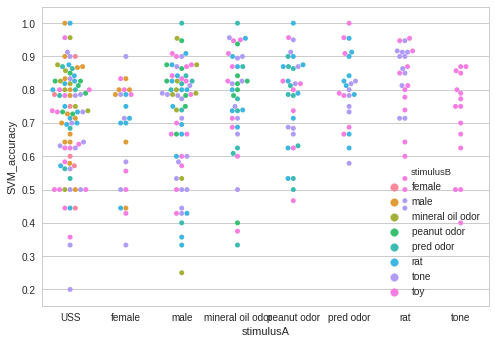

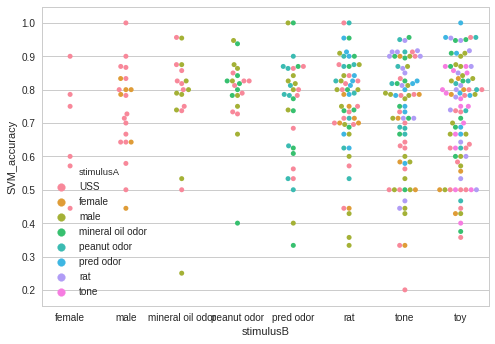

         dateOfAnalysis dateOfExperiment animal session         stimulusB  \
0   2017-07-27 20:00:54       2017_05_00      1       1            female   
1   2017-07-27 20:00:54       2017_05_00      1       2            female   
2   2017-07-27 20:00:54       2017_05_00      1       3            female   
3   2017-07-27 20:00:55       2017_05_00      3       1            female   
4   2017-07-27 20:00:55       2017_05_00      3       2            female   
5   2017-07-27 20:00:56       2017_05_00      3       3            female   
6   2017-07-27 20:00:59       2017_05_00      1       1              male   
7   2017-07-27 20:00:59       2017_05_00      1       2              male   
8   2017-07-27 20:00:59       2017_05_00      1       3              male   
9   2017-07-27 20:01:00       2017_05_00      3       1              male   
10  2017-07-27 20:01:00       2017_05_00      3       2              male   
11  2017-07-27 20:01:01       2017_05_00      3       3              male   

In [69]:
columnsTitles=["dateOfAnalysis","dateOfExperiment", "animal", "session", "stimulusB",  "stimulusA",  "SVM_accuracy"]
df_SVM_rev =df_SVM.reindex(columns=columnsTitles)

df_SVM_symmetric = df_SVM.copy()
# df_SVM_symmetric.append(df_SVM_rev.copy(), ignore_index = True)

frames = [df_SVM_symmetric, df_SVM_rev]

df_SVM_symmetric = pd.concat(frames)



sns.swarmplot(x="stimulusB", y="SVM_accuracy", hue="stimulusA",data=df_SVM)
plt.show()

print(df_SVM_rev)
print(df_SVM_symmetric[:])


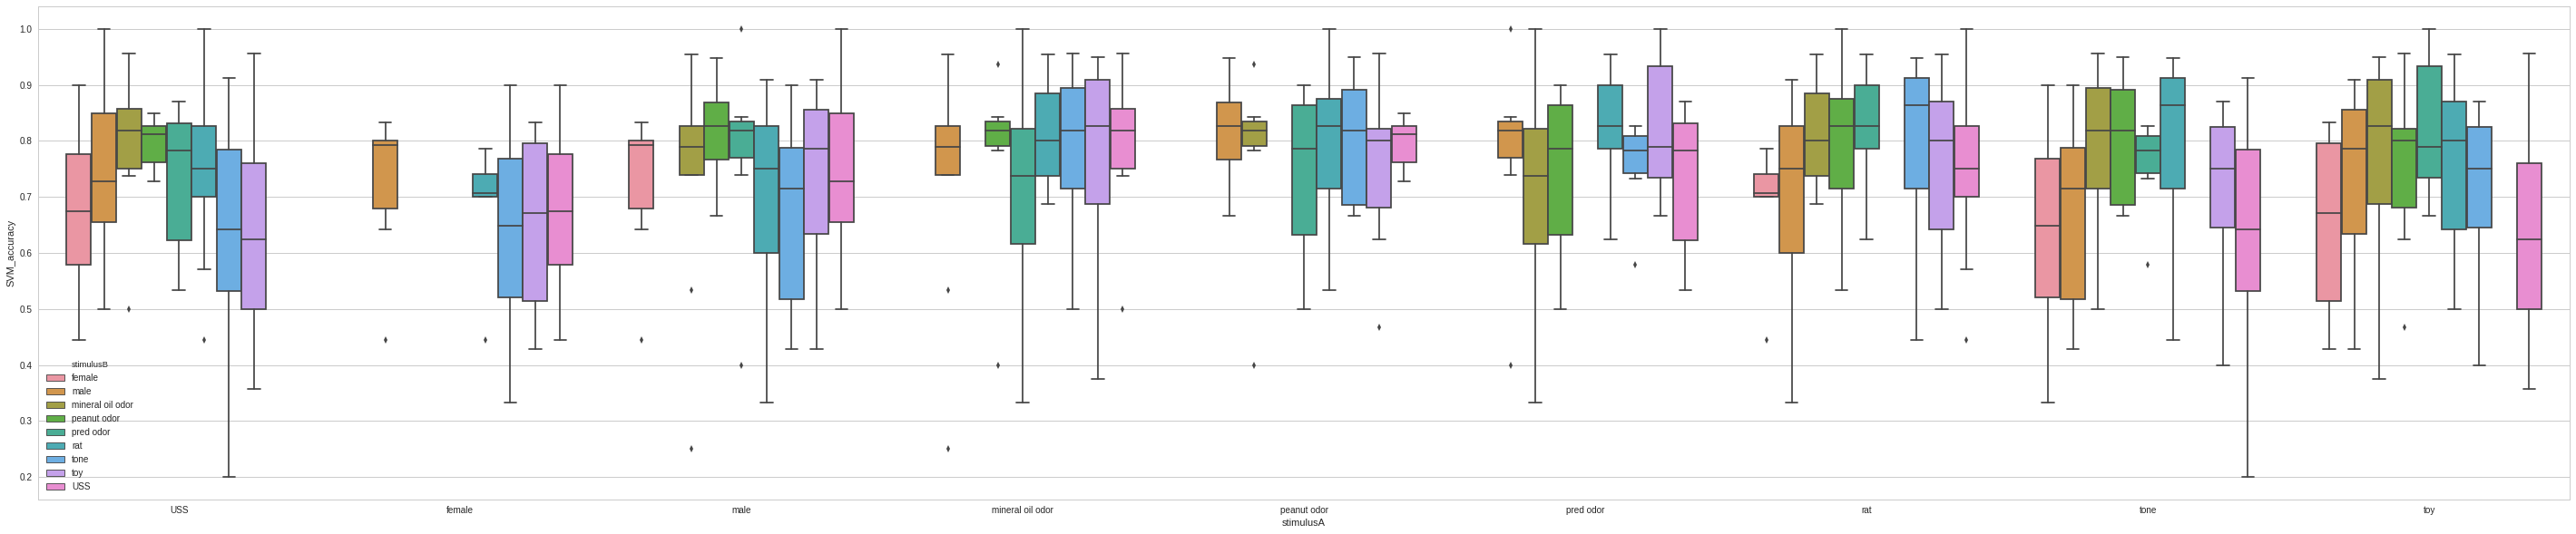

In [89]:
df_plotRaw = pd.read_csv('/home/orthogonull/a_MHR/aa_research/aa_gitResearch/git_tracked/imagingAnalysis/python/SVM_analysis_raw_symmetric_2017_07_27__14_13.csv')
sns.set(style="whitegrid", color_codes=True)

fig, ax = plt.subplots(figsize=(50,10))

# sns.swarmplot(x="stimulusA", y="SVM_accuracy", hue="stimulusB",data=df_plotRaw)
sns.boxplot(x="stimulusA", y="SVM_accuracy", hue="stimulusB",data=df_plotRaw)
# sns.violinplot(ax=ax, x="stimulusA", y="SVM_accuracy", hue="stimulusB",data=df_plotRaw)



plt.show()
# savefig('summaryFig.png')

In [35]:
stimGrouped = df_SVM.groupby(['stimulusA','stimulusB'], as_index=True)
df_SVM_summaryDesc = stimGrouped.describe()

sns.set(style="whitegrid", color_codes=True)
sns.swarmplot(x="female", y="SVM_accuracy.mean", data=df_SVM_summaryDesc)
plt.show()

print(df_SVM_summaryDesc)
print(type(df_SVM_summaryDesc))


ValueError: Could not interpret input 'female'

In [ ]:
## save summary svm data

# svmGrouped, df_SVM_summary = df_SVM.groupby(['stimulusA', 'stimulusB'], as_index=False)

# f = {'SVM_accuracy':['sum','mean'], 'B':['prod']}



print(stimGrouped.describe())      

# Write out raw analysis to csv file
OUTPUT_FILENAME = 'SVM_analysis_summary' + timestr + '.csv'
df_SVM_summaryDesc.to_csv(OUTPUT_FILENAME, header=True, index=True)

In [ ]:
## junk / notes

ratData = df.loc[df['stimulusType'] == 'rat',:]
ussData = df.loc[df['stimulusType'] == 'USS',:]

print(ussData)



df.corr()


# Rename the impact force column
df = df.rename(columns={'impact force (mN)': 'impf'})

